In [1]:
import time
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import datetime
import matplotlib.dates as mdates
from collections import deque
import numpy as np

import serial
import re

PORT = "/dev/cu.usbmodem141101"

# How many sensor samples we want to store
HISTORY_SIZE = 3000

# Pause re-sampling the sensor and drawing for INTERVAL seconds
INTERVAL = 0.0126



In [2]:
serialport = None

def get_imu_data():
    global serialport
    if not serialport:
        # open serial port
        serialport = serial.Serial(PORT, 115200, timeout=0.1)
        # check which port was really used
        print("Opened", serialport.name)
        # Flush input
        time.sleep(3)
        serialport.readline()

    # Poll the serial port
    line = str(serialport.readline(), 'utf-8')
    if not line:
        return None
    #print(line)
    if not "Uni:" in line:
        return None
    vals = line.replace("Uni:", "").strip().split(',')
    #print(vals)
    if len(vals) != 9:
        return None
    try:
        vals = [float(i) for i in vals]
    except ValueError:
        return None
    #print(vals)
    return vals

for _ in range(20):
    print(get_imu_data())

Opened /dev/cu.usbmodem141101
[0.09, -0.05, 0.92, -0.18, -1.22, -4.46, 33.36, 7.5, -39.21]
[0.1, -0.05, 1.03, -203.98, 12.51, 50.11, 33.41, 7.34, -38.76]
[0.1, -0.05, 1.03, -87.71, 6.04, 23.68, 33.62, 6.99, -39.42]
[0.09, -0.06, 0.97, -87.71, -0.79, 0.18, 33.62, 6.99, -39.42]
[0.1, -0.05, 1.0, 14.16, -0.79, 0.18, 33.75, 7.64, -38.2]
[0.1, -0.05, 1.01, 21.0, -1.28, -3.3, 34.06, 7.26, -39.32]
[0.1, -0.05, 1.01, 4.46, -0.61, -1.28, 34.06, 7.26, -39.32]
[0.1, -0.05, 1.01, 1.65, -0.31, -0.67, 34.03, 7.4, -38.94]
[0.1, -0.05, 1.0, 1.28, -0.06, -0.55, 34.06, 7.65, -38.87]
[0.1, -0.05, 1.0, 1.04, -0.06, -0.55, 34.06, 7.65, -38.87]
[0.1, -0.05, 1.0, 1.1, -0.06, -0.55, 33.06, 7.5, -39.07]
[0.1, -0.05, 1.0, 1.4, -0.31, -0.61, 33.53, 7.2, -38.51]
[0.1, -0.05, 1.0, 1.46, -0.37, -0.61, 33.53, 7.2, -38.51]
[0.1, -0.05, 1.0, 1.16, -0.61, -0.67, 33.48, 7.02, -39.59]
[0.1, -0.05, 1.0, 1.04, -0.67, -0.73, 33.51, 7.47, -38.38]
[0.1, -0.05, 1.0, 0.92, -0.61, -0.61, 33.51, 7.47, -38.38]
[0.1, -0.05, 1.0, 0.

# Magnetometer data capture

<IPython.core.display.Javascript object>


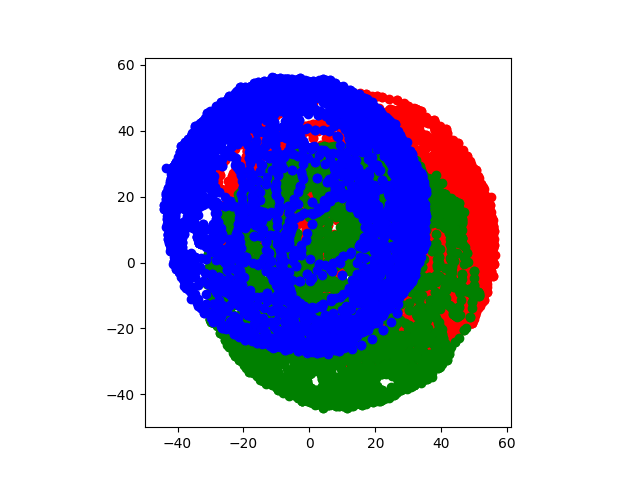

In [9]:
# Deque for axes
mag_x = deque(maxlen=HISTORY_SIZE)
mag_y = deque(maxlen=HISTORY_SIZE)
mag_z = deque(maxlen=HISTORY_SIZE)

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None
anim = None

def onClick(event):
    anim.event_source.stop()
    
def animate(i):
    for _ in range(30):
        ret = get_imu_data()
        if not ret:
            continue
        x, y, z = ret[6:9]
        mag_x.append(x)
        mag_y.append(y)
        mag_z.append(z)

    # Clear all axis
    ax.cla()

    # Display the sub-plots
    ax.scatter(mag_x, mag_y, color='r')
    ax.scatter(mag_y, mag_z, color='g')
    ax.scatter(mag_z, mag_x, color='b')
    
    if len(mag_x) == HISTORY_SIZE:
        anim.event_source.stop()
    # Pause the plot for INTERVAL seconds 
    plt.pause(INTERVAL)

fig.canvas.mpl_connect('button_press_event', onClick)    
anim = FuncAnimation(fig, animate)

X range:  -27.64 56.23
Y range:  -30.99 51.62
Z range:  -44.12 35.46
Final calibration in uTesla: [14.294999999999998, 10.315, -4.329999999999998]


<IPython.core.display.Javascript object>


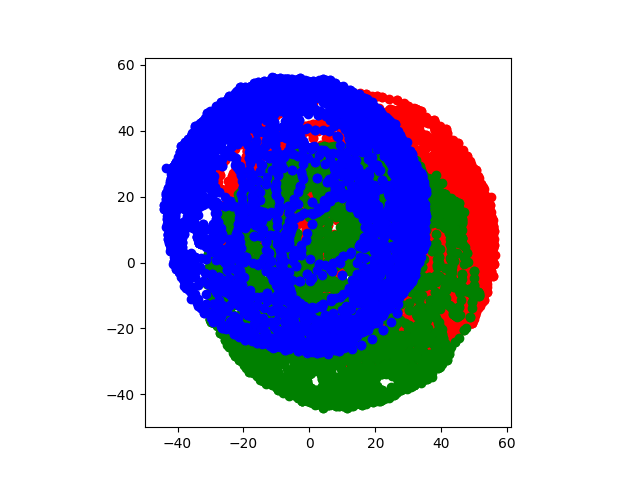

In [10]:
min_x = min(mag_x)
max_x = max(mag_x)
min_y = min(mag_y)
max_y = max(mag_y)
min_z = min(mag_z)
max_z = max(mag_z)

print("X range: ", min_x, max_x)
print("Y range: ", min_y, max_y)
print("Z range: ", min_z, max_z)

mag_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in uTesla:", mag_calibration)

cal_mag_x = [x - mag_calibration[0] for x in mag_x]
cal_mag_y = [y - mag_calibration[1] for y in mag_y]
cal_mag_z = [z - mag_calibration[2] for z in mag_z]

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# Clear all axis
ax.cla()

# Display the now calibrated data
ax.scatter(cal_mag_x, cal_mag_y, color='r')
ax.scatter(cal_mag_y, cal_mag_z, color='g')
ax.scatter(cal_mag_z, cal_mag_x, color='b')
fig.show()

# Gyroscope offset calibration

Put down the board and do not touch or move it!
3...2...1...COLLECTING GYRO DATA
Opened /dev/cu.usbmodem141101
Gyro X range:  1.22 1.95
Gyro Y range:  -0.61 -0.06
Gyro Z range:  -0.67 -0.24
Final calibration in rad/s: [1.585, -0.33499999999999996, -0.455]


<IPython.core.display.Javascript object>


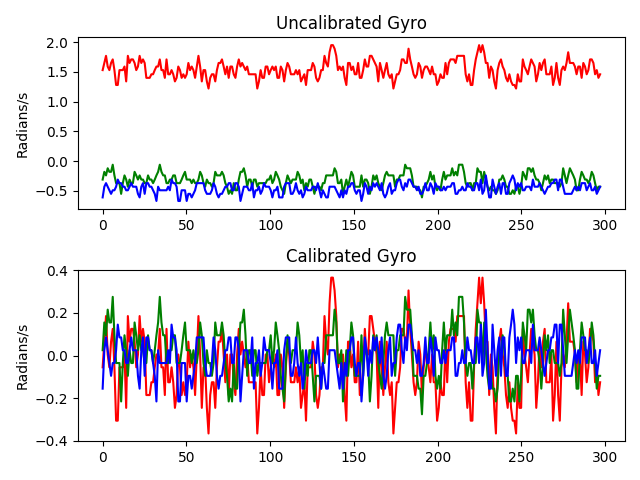

In [17]:
print("Put down the board and do not touch or move it!")
for s in range(3, 0, -1):
    print(s, end='...')
    time.sleep(1)
print("COLLECTING GYRO DATA")

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None

# Deque for axes
gyro_x = deque(maxlen=HISTORY_SIZE//10)
gyro_y = deque(maxlen=HISTORY_SIZE//10)
gyro_z = deque(maxlen=HISTORY_SIZE//10)
while len(gyro_x) < (HISTORY_SIZE//10):
    ret = get_imu_data()
    #print(ret)
    if not ret:
        continue
    x, y, z = ret[3:6]
    gyro_x.append(x)
    gyro_y.append(y)
    gyro_z.append(z)

for _ in range(3):
    gyro_x.popleft()
    gyro_y.popleft()
    gyro_z.popleft()

min_x = min(gyro_x)
max_x = max(gyro_x)
min_y = min(gyro_y)
max_y = max(gyro_y)
min_z = min(gyro_z)
max_z = max(gyro_z)

print("Gyro X range: ", min_x, max_x)
print("Gyro Y range: ", min_y, max_y)
print("Gyro Z range: ", min_z, max_z)

gyro_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in rad/s:", gyro_calibration)

fig, (uncal, cal) = plt.subplots(2, 1)

# Clear all axis
uncal.cla()
t = np.linspace(0, len(gyro_x), len(gyro_x))
# plot uncalibrated data
uncal.plot(t, gyro_x, color='r')
uncal.plot(t, gyro_y, color='g')
uncal.plot(t, gyro_z, color='b')
uncal.title.set_text("Uncalibrated Gyro")
uncal.set(ylabel='Radians/s')
# plot calibrated data
cal.plot(t, [x - gyro_calibration[0] for x in gyro_x], color='r')
cal.plot(t, [y - gyro_calibration[1] for y in gyro_y], color='g')
cal.plot(t, [z - gyro_calibration[2] for z in gyro_z], color='b')
cal.title.set_text("Calibrated Gyro")
cal.set(ylabel='Radians/s')

fig.tight_layout()
fig.show()
serialport.close()

# Accelerometer offset calibration

Put down the board and do not touch or move it!
3...2...1...COLLECTING ACC DATA
Opened /dev/cu.usbmodem141101
Acc X range:  0.57 0.58
Acc Y range:  0.02 0.02
Acc Z range:  0.83 0.83
Final calibration in mg: [0.575, 0.02, 0.83]


<IPython.core.display.Javascript object>


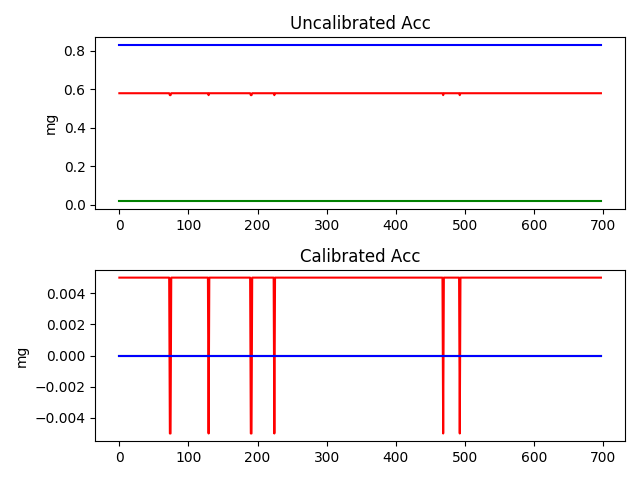

In [28]:
# How many sensor samples we want to store
HISTORY_SIZE = 7000

print("Put down the board and do not touch or move it!")
for s in range(3, 0, -1):
    print(s, end='...')
    time.sleep(1)
print("COLLECTING ACC DATA")

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None

# Deque for axes
acc_x = deque(maxlen=HISTORY_SIZE//10)
acc_y = deque(maxlen=HISTORY_SIZE//10)
acc_z = deque(maxlen=HISTORY_SIZE//10)
while len(acc_x) < (HISTORY_SIZE//10):
    ret = get_imu_data()
    #print(ret)
    if not ret:
        continue
    x, y, z = ret[:3]
    acc_x.append(x)
    acc_y.append(y)
    acc_z.append(z)

for _ in range(3):
    acc_x.popleft()
    acc_y.popleft()
    acc_z.popleft()

min_x = min(acc_x)
max_x = max(acc_x)
min_y = min(acc_y)
max_y = max(acc_y)
min_z = min(acc_z)
max_z = max(acc_z)

print("Acc X range: ", min_x, max_x)
print("Acc Y range: ", min_y, max_y)
print("Acc Z range: ", min_z, max_z)

acc_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in mg:", acc_calibration)

fig, (uncal, cal) = plt.subplots(2, 1)

# Clear all axis
uncal.cla()
t = np.linspace(0, len(acc_x), len(acc_x))
# plot uncalibrated data
uncal.plot(t, acc_x, color='r')
uncal.plot(t, acc_y, color='g')
uncal.plot(t, acc_z, color='b')
uncal.title.set_text("Uncalibrated Acc")
uncal.set(ylabel='mg')
# plot calibrated data
cal.plot(t, [x - acc_calibration[0] for x in acc_x], color='r')
cal.plot(t, [y - acc_calibration[1] for y in acc_y], color='g')
cal.plot(t, [z - acc_calibration[2] for z in acc_z], color='b')
cal.title.set_text("Calibrated Acc")
cal.set(ylabel='mg')

fig.tight_layout()
fig.show()
serialport.close()

# Accelerometer calibration using Sphere approach

## Accelerometer data capture

<IPython.core.display.Javascript object>


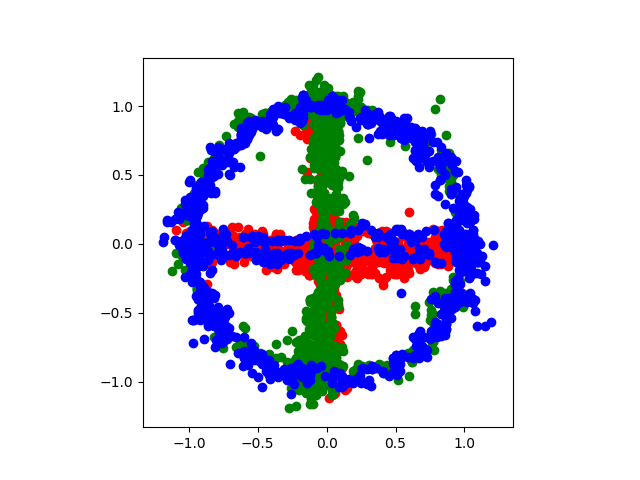

In [12]:
# Deque for axes
HISTORY_SIZE = 8000
acc_x = deque(maxlen=HISTORY_SIZE)
acc_y = deque(maxlen=HISTORY_SIZE)
acc_z = deque(maxlen=HISTORY_SIZE)

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None
anim = None

def onClick(event):
    anim.event_source.stop()
    
def animate(i):
    for _ in range(30):
        ret = get_imu_data()
        if not ret:
            continue
        x, y, z = ret[:3]
        acc_x.append(x)
        acc_y.append(y)
        acc_z.append(z)

    # Clear all axis
    ax.cla()

    # Display the sub-plots
    ax.scatter(acc_x, acc_y, color='r')
    ax.scatter(acc_y, acc_z, color='g')
    ax.scatter(acc_z, acc_x, color='b')
    
    if len(acc_x) == HISTORY_SIZE:
        anim.event_source.stop()
    # Pause the plot for INTERVAL seconds 
    plt.pause(INTERVAL)

fig.canvas.mpl_connect('button_press_event', onClick)    
anim = FuncAnimation(fig, animate)

<IPython.core.display.Javascript object>


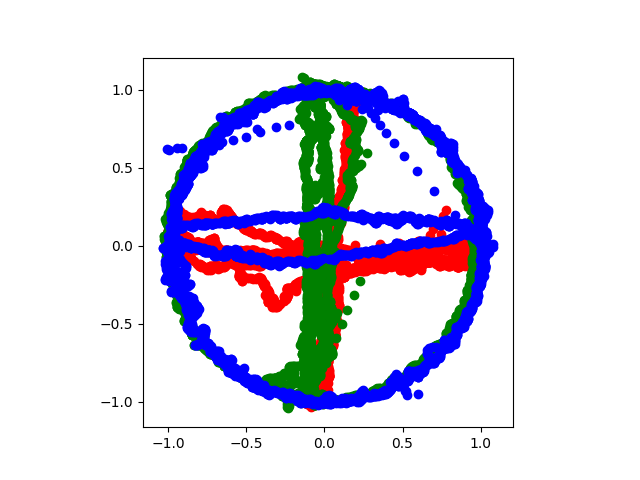

In [5]:
# Deque for axes
HISTORY_SIZE = 8000
acc_x = deque(maxlen=HISTORY_SIZE)
acc_y = deque(maxlen=HISTORY_SIZE)
acc_z = deque(maxlen=HISTORY_SIZE)

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# close port in case its open
if serialport:
    try:
        serialport.close()
    except NameError:
        pass

serialport = None
anim = None

alpha = 0.8;
gravity_x, gravity_y, gravity_z = [0],  [0], [1]

def onClick(event):
    anim.event_source.stop()
    
def animate(i):
    for _ in range(30):
        ret = get_imu_data()
        if not ret:
            continue
        x, y, z = ret[:3]
        acc_x.append(x)
        acc_y.append(y)
        acc_z.append(z)
    
        gravity_z.append(alpha * gravity_z[-1] + (1 - alpha) * z)

        gravity_y.append(alpha * gravity_y[-1] + (1 - alpha) * y)

        gravity_x.append(alpha * gravity_x[-1] + (1 - alpha) * x)
    
    # Clear all axis
    ax.cla()

    # Display the sub-plots
    ax.scatter(gravity_x, gravity_y, color='r')
    ax.scatter(gravity_y, gravity_z, color='g')
    ax.scatter(gravity_z, gravity_x, color='b')
    
    if len(acc_x) == HISTORY_SIZE:
        anim.event_source.stop()
    # Pause the plot for INTERVAL seconds 
    plt.pause(INTERVAL)

fig.canvas.mpl_connect('button_press_event', onClick)    
anim = FuncAnimation(fig, animate)

X range:  -1.09 1.08
Y range:  -1.12 1.04
Z range:  -1.19 1.21
Final calibration in mg: [-0.0050000000000000044, -0.040000000000000036, 0.010000000000000009]


<IPython.core.display.Javascript object>


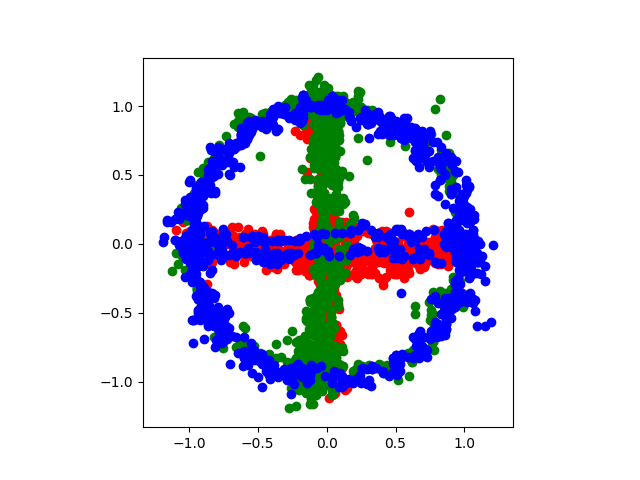

In [13]:
min_x = min(acc_x)
max_x = max(acc_x)
min_y = min(acc_y)
max_y = max(acc_y)
min_z = min(acc_z)
max_z = max(acc_z)

print("X range: ", min_x, max_x)
print("Y range: ", min_y, max_y)
print("Z range: ", min_z, max_z)

acc_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in mg:", acc_calibration)

cal_acc_x = [x - acc_calibration[0] for x in acc_x]
cal_acc_y = [y - acc_calibration[1] for y in acc_y]
cal_acc_z = [z - acc_calibration[2] for z in acc_z]

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# Clear all axis
ax.cla()

# Display the now calibrated data
ax.scatter(cal_acc_x, cal_acc_y, color='r')
ax.scatter(cal_acc_y, cal_acc_z, color='g')
ax.scatter(cal_acc_z, cal_acc_x, color='b')
fig.show()

X range:  -1.0167122466645067 1.0216791299447334
Y range:  -1.0306575560992466 0.9911232249084254
Z range:  -1.0356324501778262 1.1295850823653095
Final calibration in mg: [0.002483441640113382, -0.019767165595410585, 0.046976316093741644]


<IPython.core.display.Javascript object>


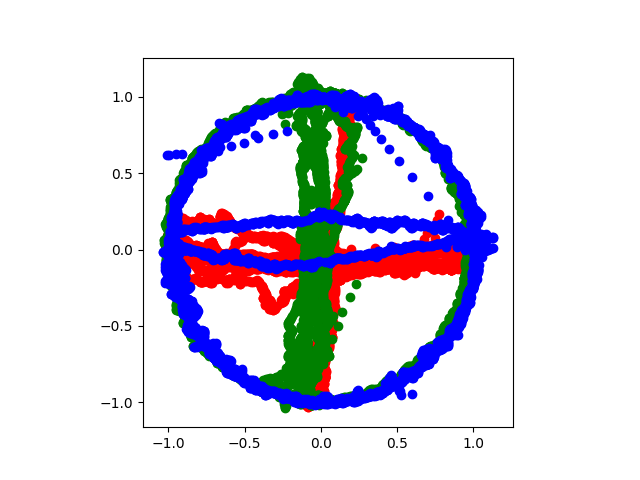

In [7]:
min_x = min(gravity_x)
max_x = max(gravity_x)
min_y = min(gravity_y)
max_y = max(gravity_y)
min_z = min(gravity_z)
max_z = max(gravity_z)

print("X range: ", min_x, max_x)
print("Y range: ", min_y, max_y)
print("Z range: ", min_z, max_z)

acc_calibration = [ (max_x + min_x) / 2, (max_y + min_y) / 2, (max_z + min_z) / 2]
print("Final calibration in mg:", acc_calibration)

cal_acc_x = [x - acc_calibration[0] for x in gravity_x]
cal_acc_y = [y - acc_calibration[1] for y in gravity_y]
cal_acc_z = [z - acc_calibration[2] for z in gravity_z]

fig, ax = plt.subplots(1, 1)
ax.set_aspect(1)

# Clear all axis
ax.cla()

# Display the now calibrated data
ax.scatter(cal_acc_x, cal_acc_y, color='r')
ax.scatter(cal_acc_y, cal_acc_z, color='g')
ax.scatter(cal_acc_z, cal_acc_x, color='b')
fig.show()